# Text Analytics Pipeline for Text Classification

This notebook demonstrates how to build a text analytics pipeline that includes text processing, feature extraction, classification, and evaluation.


Install below dependancies/modules in order to to re-run this notebook:

In [17]:
# %pip install pandas numpy nltk emoji spacy contractions scikit-learn imbalanced-learn
# !python -m spacy download en_core_web_sm

To Download the dataset:

In [18]:
# Pipeline to load or download the dataset
# """
# TODO
# """

To Download GloVe pretrained word vectors :

In [19]:
# Pipeline to load or download the dataset
# """
# TODO
# """

Modules:

In [20]:
import pandas as pd
import numpy as np
import re
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer  
from nltk.corpus import stopwords
import emoji
import spacy
import contractions

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)
from sklearn.decomposition import TruncatedSVD
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# A. 1. Custom Text Preprocessor

The custom transformer below:

 - **Emoji Conversion:** Converts any emojis to their text descriptions.
 - **Normalization:** Lowercases the text.
 - **Punctuation Removal:** Removes punctuation using regex.
 - **Tokenization:** Uses NLTK’s `word_tokenize`.
 - **Stop-word Removal:** Filters out English stopwords.
 - **Stemming:** Applies Porter stemming.
 
 The transformer implements `fit` and `transform` so that it can be used inside a scikit-learn pipeline.

In [21]:
class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, do_stemming=True, do_lemmatization=False, remove_stopwords=True, 
                 do_emoji_conversion=True, use_spacy_tokenizer=True):
        """
        Parameters:
        - do_stemming: Apply stemming (reduces words to their root form)
        - do_lemmatization: Apply lemmatization (converts words to their canonical form)
          Note: When using the default (NLTK) tokenizer, if both do_lemmatization and do_stemming are enabled,
          lemmatization takes precedence.
        - remove_stopwords: Remove common stopwords
        - do_emoji_conversion: Convert emojis to text descriptions
        - use_spacy_tokenizer: Use a custom spaCy-based tokenizer (which already uses lemmatization)
        """
        self.do_stemming = do_stemming
        self.do_lemmatization = do_lemmatization
        self.remove_stopwords = remove_stopwords
        self.do_emoji_conversion = do_emoji_conversion
        self.use_spacy_tokenizer = use_spacy_tokenizer
        self.stemmer = PorterStemmer()
        if self.do_lemmatization:
            self.lemmatizer = WordNetLemmatizer()
        self.stop_words = set(stopwords.words('english'))
        
        # Load the spaCy model if using the spaCy tokenizer
        if self.use_spacy_tokenizer:
            self.nlp = spacy.load("en_core_web_sm")
    
    def remove_links(self, text):
        """Remove URLs from text."""
        return re.sub(r'http[s]?://\S+|www\.\S+', '', text)
    
    def remove_user_mentions(self, text):
        """Remove user mentions from text."""
        return re.sub(r'u/\S+', '', text)
    
    def expand_contractions(self, text):
        """Expand contractions in the text."""
        return contractions.fix(text)
    
    def remove_non_ascii(self, text):
        """Remove non-ASCII characters from the text."""
        return text.encode("ascii", "ignore").decode()
    
    def remove_punctuations(self, text):
        """
        Remove or adjust punctuation in text.
        Replaces hyphens with space and ensures separation around punctuation.
        """
        text = re.sub(r'[-]', ' ', text)
        text = re.sub(r'(\S)[' + re.escape(string.punctuation) + r'](\S)', r'\1 \2', text)
        return text
    
    def remove_numbers(self, text):
        """Remove numbers from text."""
        return re.sub(r'[0-9]+', '', text)
    
    def emoji_to_text(self, text):
        """Convert emojis to text descriptions."""
        return emoji.demojize(text)
    
    def normalize(self, text):
        """Lowercase the text."""
        return text.lower()
    
    def tokenize(self, text):
        """
        Tokenize text using either a spaCy-based custom tokenizer or the default NLTK tokenizer.
        """
        if self.use_spacy_tokenizer:
            # Use spaCy's custom tokenization logic:
            doc = self.nlp(text)
            tokens = []
            # Add named entities as tokens
            for ent in doc.ents:
                tokens.append(ent.text)
            # Add non-entity tokens using their lemma
            non_entity_tokens = [token.lemma_.lower() for token in doc if not token.ent_type_ 
                                 and not token.is_punct and not token.is_space]
            tokens.extend(non_entity_tokens)
            if self.remove_stopwords:
                tokens = [token for token in tokens if token.lower() not in self.stop_words]
            if self.do_stemming:
                tokens = [self.stemmer.stem(token) for token in tokens]
            return tokens
        else:
            # Default NLTK-based tokenization:
            # Remove punctuation (if any remains) and then tokenize
            text = re.sub(r'[^\w\s]', '', text)
            tokens = word_tokenize(text)
            # Keep only alphabetic tokens
            tokens = [token for token in tokens if token.isalpha()]
            if self.remove_stopwords:
                tokens = [token for token in tokens if token.lower() not in self.stop_words]
            # Apply lemmatization if enabled; otherwise, apply stemming if enabled
            if self.do_lemmatization:
                tokens = [self.lemmatizer.lemmatize(token) for token in tokens]
            elif self.do_stemming:
                tokens = [self.stemmer.stem(token) for token in tokens]
            return tokens
    
    def preprocess(self, text):
        """Apply the complete preprocessing pipeline to the text."""
        text = self.remove_links(text)
        text = self.remove_user_mentions(text)
        text = self.expand_contractions(text)
        text = self.remove_non_ascii(text)
        text = self.remove_punctuations(text)
        text = self.remove_numbers(text)
        if self.do_emoji_conversion:
            text = self.emoji_to_text(text)
        text = self.normalize(text)
        tokens = self.tokenize(text)
        return ' '.join(tokens)
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X.apply(self.preprocess)

# A. 2. Custom Text Preprocessor (Without Punctuation Removal)

The custom transformer below:

 - **Emoji Conversion:** Converts any emojis to their text descriptions.
 - **Normalization:** Lowercases the text.
 - **Tokenization:** Uses NLTK’s `word_tokenize`.
 - **Stop-word Removal:** Filters out English stopwords.
 - **Stemming:** Applies Porter stemming.
 
 The transformer implements `fit` and `transform` so that it can be used inside a scikit-learn pipeline.

In [22]:
class TextPreprocessorNoPunct(TextPreprocessor):
    def preprocess(self, text):
        """Same as TextPreprocessor.preprocess but without removing punctuation."""
        text = self.remove_links(text)
        text = self.remove_user_mentions(text)
        text = self.expand_contractions(text)
        text = self.remove_non_ascii(text)
        # Skip punctuation removal:
        # text = self.remove_punctuations(text)
        text = self.remove_numbers(text)
        if self.do_emoji_conversion:
            text = self.emoji_to_text(text)
        text = self.normalize(text)
        tokens = self.tokenize(text)
        return ' '.join(tokens)

### GloveVectorizer Class

#### Theoretical Aspects of the GloVe Vectorizer

**GloVe** (Global Vectors for Word Representation) is an unsupervised learning algorithm designed to capture the semantic relationships between words by leveraging global co-occurrence statistics from a text corpus. Unlike methods such as word2vec that rely on local context (i.e., neighboring words), GloVe builds a global word-word co-occurrence matrix and uses this information to generate word embeddings.

---

##### The `glove.twitter.27B.50d.txt` Embeddings

- **Corpus Origin:**  
  The file `glove.twitter.27B.50d.txt` contains pre-trained GloVe embeddings derived from a massive corpus of Twitter data. This corpus is rich in informal language, slang, and abbreviations, making these embeddings particularly useful for social media text analysis.

- **Embedding Dimensions:**  
  Each word is represented by a 50-dimensional vector. The choice of 50 dimensions strikes a balance between computational efficiency and the ability to capture semantic nuances.

- **Development:**  
  The GloVe algorithm was developed by researchers at Stanford University, including Jeffrey Pennington, Richard Socher, and Christopher Manning. Their work provided a novel way to combine global statistical information with efficient vector learning, greatly influencing the field of Natural Language Processing (NLP).

---


In our project, the `GloveVectorizer` is used to transform text data into numerical features by leveraging pre-trained GloVe embeddings. This approach provides semantic-rich, dense vector representations of documents, which can improve model performance over traditional sparse representations.


#### Key Components

- **`__init__`:**  
  Initializes the vectorizer with the GloVe file path and embedding dimension.

- **`fit`:**  
  Loads the GloVe embeddings into a dictionary for quick lookup.

- **`transform`:**  
  Converts each document into an average embedding vector by:
  - Splitting the text into tokens.
  - Retrieving the corresponding embedding for each token.
  - Averaging these embeddings to form a single vector for the document.

This vectorizer is essential for capturing the contextual meaning of words, enhancing the classifier's ability to understand and process text data.

In [23]:
class GloveVectorizer(BaseEstimator, TransformerMixin):
    """
    Loading pre-trained GloVe embeddings and returns the average embedding vector for each document.
    """
    def __init__(self, glove_file='glove.twitter.27B.50d.txt', embedding_dim=50):
        self.glove_file = glove_file
        self.embedding_dim = embedding_dim

    def fit(self, X, y=None):
        self.embeddings_index = {}
        with open(self.glove_file, encoding="utf8") as f:
            for line in f:
                values = line.split()
                word = values[0]
                coefs = np.asarray(values[1:], dtype='float32')
                self.embeddings_index[word] = coefs
        return self

    def transform(self, X):
        vectors = []
        for doc in X:
            # Since TextPreprocessor returns a space-separated string of tokens,
            # we can simply split on spaces.
            tokens = doc.split()
            token_vecs = [self.embeddings_index[token] for token in tokens if token in self.embeddings_index]
            if token_vecs:
                doc_vec = np.mean(token_vecs, axis=0)
            else:
                doc_vec = np.zeros(self.embedding_dim)
            vectors.append(doc_vec)
        return np.array(vectors)

### Helper to Insert SVD

The `add_svd` function is designed to enhance an existing scikit-learn pipeline by inserting a dimensionality reduction step using `TruncatedSVD`. This is particularly useful when working with high-dimensional data from vectorizers such as `CountVectorizer` or `TfidfVectorizer`.


In [24]:
# Helper to Insert SVD 
def add_svd(pipeline, n_components=100):
    """
    Inserts a TruncatedSVD step right after the vectorizer.
    Assumes the pipeline has steps: preprocessor, vectorizer, classifier.
    Returns an imblearn Pipeline if the input pipeline is an imblearn Pipeline.
    """
    steps = pipeline.steps.copy()
    # Insert SVD at position 2 (right after vectorizer)
    steps.insert(2, ('svd', TruncatedSVD(n_components=n_components)))
    
    # Return an imblearn pipeline if the original was an imblearn pipeline
    if isinstance(pipeline, ImbPipeline):
        return ImbPipeline(steps)
    return Pipeline(steps)

 # B. Data Loading and Train/Test Split
 
 We load the dataset and split it into training (80%) and testing (20%) sets.

In [25]:
# Read the dataset 
df = pd.read_csv("../Data/labelled_data.csv")

# Check available columns
print("Columns in dataset:", df.columns.tolist())

# Select the important columns and drop any missing values
df = df[['text', 'label']].dropna()
X = df['text']
y = df['label']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Columns in dataset: ['post_id', 'subreddit', 'post_title', 'post_body', 'number_of_comments', 'readable_datetime', 'post_author', 'number_of_upvotes', 'query', 'text', 'comment_id', 'comment_body', 'comment_author', 'label']


___________________________________________________________________________________________________________________________________________________________________________________________________________________________________________

# C. Stage 1: Basic Pipelines

## Overview

This script defines a comprehensive suite of text classification pipelines. The pipelines are constructed to evaluate different combinations of text preprocessing, feature extraction, and classification algorithms. They also address class imbalance using methods like Random Under Sampling.

---

## Components

### Preprocessing Modules

- **TextPreprocessor**
  - Cleans the text by:
    - Removing URLs, user mentions, non-ASCII characters, numbers, and punctuation.
    - Expanding contractions and converting emojis to text.
    - Normalizing text (lowercasing and tokenizing).
  - Uses a spaCy-based tokenizer for lemmatization and stopword removal.

- **TextPreprocessorNoPunct**
  - Inherits from `TextPreprocessor` but **does not remove punctuation**.
  - Allows evaluation of the effect of preserving punctuation on model performance.

### Vectorization

- **CountVectorizer**
  - Converts text to a binary bag-of-words representation.
  - Configurable to use unigrams or n-grams (1,2).

- **TfidfVectorizer**
  - Transforms text into TF-IDF features.
  - Also available in both unigram and n-gram modes.

- **GloveVectorizer**
  - Loads pre-trained GloVe embeddings.
  - Represents documents by averaging the embeddings of individual words.

### Classification Algorithms

- **Logistic Regression**
  - Configured with `max_iter=1000` and `class_weight='balanced'` for imbalance correction.

- **Support Vector Machines (SVM)**
  - Implemented using `LinearSVC` with similar settings for balancing.

- **Random Forest**
  - Uses 100 estimators and a fixed random seed with balanced class weights.

- **Naive Bayes**
  - Uses `MultinomialNB` within an imbalanced-learn pipeline.
  - Balances classes using a `RandomUnderSampler`.

- **K-Nearest Neighbors (KNN)**
  - KNN does not support internal class weighting.
  - Each KNN pipeline incorporates a `RandomUnderSampler` to balance classes.
  - Pipelines are available in both:
    - Standard form (with punctuation removal via `TextPreprocessor`).
    - With punctuation preserved (via `TextPreprocessorNoPunct`).
  - Glove-based variants are also included.

### Balancing Strategy

- **RandomUnderSampler (RUS)**
  - Added as a pipeline step (using imbalanced-learn's `ImbPipeline`) to balance classes.
  - Incorporated in pipelines for Naive Bayes and KNN, among others.

### Dimensionality Reduction (SVD)

- A helper function `add_svd` inserts a `TruncatedSVD` step after the vectorizer.
- SVD-enhanced pipelines are generated for classifiers other than Naive Bayes.

---

### Pipeline Variants

#### With Standard Preprocessing (Punctuation Removed)

- **Logistic Regression, SVM, Random Forest, and Naive Bayes**
  - Each classifier is paired with both Count and TF-IDF vectorizers.
  - Variants use either unigram or n-gram configurations.
  - Class imbalance is addressed via the classifier’s built-in options or by applying a `RandomUnderSampler`.

- **Glove Pipelines**
  - Use the `GloveVectorizer` for obtaining average word embeddings.
  - Followed by classifiers such as Logistic Regression, SVM, or Random Forest.

#### With Punctuation Preserved

- Pipelines mirror the standard versions but use `TextPreprocessorNoPunct`.
- Allows a direct comparison to assess the impact of punctuation removal on model performance.

#### KNN Pipelines

- **Standard KNN Pipelines**
  - Utilize `TextPreprocessor` (punctuation removed).
  - Include a `RandomUnderSampler` to handle class imbalance.
  - Available for both Count and TF-IDF representations.

- **KNN Pipelines with Punctuation Preserved**
  - Use `TextPreprocessorNoPunct` to retain punctuation.
  - Also include a `RandomUnderSampler` for balancing.
  
- **Glove-based KNN Pipelines**
  - Use `GloveVectorizer` with both preprocessing variants.

---

### Pipeline Collection

All pipelines are aggregated into a master dictionary (`all_pipelines`). This dictionary includes:
- SVD-enhanced versions for applicable pipelines.
- Variants across different classifiers: LR, SVM, RF, NB, and KNN.
- Both standard and punctuation-preserving versions.
- Glove-based pipelines for embedding comparisons.

This structure facilitates systematic evaluation of each pipeline, comparing the effects of various preprocessing and modeling choices on text classification performance.


### Kewords:

- lr -> Logistic Regression
- SVM -> Support vector machine
- RF -> Random Forest
- NB -> Multinomial Naive Bayes
- KNN -> K-Nearest Neighbors
- WithPunct -> Did not perform puntuation removal

In [26]:
# Logistic Regression Pipelines
pipeline_lr_count_unigram = Pipeline([
    ('preprocessor', TextPreprocessor()),
    ('vectorizer', CountVectorizer(binary=True, ngram_range=(1,1))),
    ('classifier', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

pipeline_lr_count_ngram = Pipeline([
    ('preprocessor', TextPreprocessor()),
    ('vectorizer', CountVectorizer(binary=True, ngram_range=(1,2))),
    ('classifier', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

pipeline_lr_tfidf_unigram = Pipeline([
    ('preprocessor', TextPreprocessor()),
    ('vectorizer', TfidfVectorizer(ngram_range=(1,1))),
    ('classifier', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

pipeline_lr_tfidf_ngram = Pipeline([
    ('preprocessor', TextPreprocessor()),
    ('vectorizer', TfidfVectorizer(ngram_range=(1,2))),
    ('classifier', LogisticRegression(max_iter=1000, class_weight='balanced'))
])


# SVM Pipelines
pipeline_svm_count_unigram = Pipeline([
    ('preprocessor', TextPreprocessor()),
    ('vectorizer', CountVectorizer(binary=True, ngram_range=(1,1))),
    ('classifier', LinearSVC(max_iter=1000, class_weight='balanced'))
])

pipeline_svm_count_ngram = Pipeline([
    ('preprocessor', TextPreprocessor()),
    ('vectorizer', CountVectorizer(binary=True, ngram_range=(1,2))),
    ('classifier', LinearSVC(max_iter=1000, class_weight='balanced'))
])

pipeline_svm_tfidf_unigram = Pipeline([
    ('preprocessor', TextPreprocessor()),
    ('vectorizer', TfidfVectorizer(ngram_range=(1,1))),
    ('classifier', LinearSVC(max_iter=1000, class_weight='balanced'))
])

pipeline_svm_tfidf_ngram = Pipeline([
    ('preprocessor', TextPreprocessor()),
    ('vectorizer', TfidfVectorizer(ngram_range=(1,2))),
    ('classifier', LinearSVC(max_iter=1000, class_weight='balanced'))
])


# Random Forest Pipelines
pipeline_rf_count_unigram = Pipeline([
    ('preprocessor', TextPreprocessor()),
    ('vectorizer', CountVectorizer(binary=True, ngram_range=(1,1))),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'))
])

pipeline_rf_count_ngram = Pipeline([
    ('preprocessor', TextPreprocessor()),
    ('vectorizer', CountVectorizer(binary=True, ngram_range=(1,2))),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'))
])

pipeline_rf_tfidf_unigram = Pipeline([
    ('preprocessor', TextPreprocessor()),
    ('vectorizer', TfidfVectorizer(ngram_range=(1,1))),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'))
])

pipeline_rf_tfidf_ngram = Pipeline([
    ('preprocessor', TextPreprocessor()),
    ('vectorizer', TfidfVectorizer(ngram_range=(1,2))),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'))
])


# Naive Bayes Pipelines (with Random Under-Sampling)
pipeline_nb_count_unigram = ImbPipeline([
    ('preprocessor', TextPreprocessor()),
    ('vectorizer', CountVectorizer(binary=True, ngram_range=(1,1))),
    ('sampler', RandomUnderSampler(random_state=42)),
    ('classifier', MultinomialNB())
])

pipeline_nb_count_ngram = ImbPipeline([
    ('preprocessor', TextPreprocessor()),
    ('vectorizer', CountVectorizer(binary=True, ngram_range=(1,2))),
    ('sampler', RandomUnderSampler(random_state=42)),
    ('classifier', MultinomialNB())
])

pipeline_nb_tfidf_unigram = ImbPipeline([
    ('preprocessor', TextPreprocessor()),
    ('vectorizer', TfidfVectorizer(ngram_range=(1,1))),
    ('sampler', RandomUnderSampler(random_state=42)),
    ('classifier', MultinomialNB())
])

pipeline_nb_tfidf_ngram = ImbPipeline([
    ('preprocessor', TextPreprocessor()),
    ('vectorizer', TfidfVectorizer(ngram_range=(1,2))),
    ('sampler', RandomUnderSampler(random_state=42)),
    ('classifier', MultinomialNB())
])


# SVD versions for non-Naive Bayes pipelines
pipelines_no_svd = {
    "NB_Count_Binary_Unigram": pipeline_nb_count_unigram,
    "NB_Count_Binary_Ngram": pipeline_nb_count_ngram,
    "NB_Tfidf_Unigram": pipeline_nb_tfidf_unigram,
    "NB_Tfidf_Ngram": pipeline_nb_tfidf_ngram,
}

other_pipelines = {
    "LR_Count_Binary_Unigram": pipeline_lr_count_unigram,
    "LR_Count_Binary_Ngram": pipeline_lr_count_ngram,
    "LR_Tfidf_Unigram": pipeline_lr_tfidf_unigram,
    "LR_Tfidf_Ngram": pipeline_lr_tfidf_ngram,
    
    "SVM_Count_Binary_Unigram": pipeline_svm_count_unigram,
    "SVM_Count_Binary_Ngram": pipeline_svm_count_ngram,
    "SVM_Tfidf_Unigram": pipeline_svm_tfidf_unigram,
    "SVM_Tfidf_Ngram": pipeline_svm_tfidf_ngram,
    
    "RF_Count_Binary_Unigram": pipeline_rf_count_unigram,
    "RF_Count_Binary_Ngram": pipeline_rf_count_ngram,
    "RF_Tfidf_Unigram": pipeline_rf_tfidf_unigram,
    "RF_Tfidf_Ngram": pipeline_rf_tfidf_ngram,
}

svd_pipelines = {name + "_SVD": add_svd(pipe) for name, pipe in other_pipelines.items()}

# Glove pipelines
pipeline_glove_lr = Pipeline([
    ('preprocessor', TextPreprocessor()),
    ('glove', GloveVectorizer(glove_file='glove.twitter.27B.50d.txt', embedding_dim=50)),
    ('classifier', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

pipeline_glove_svm = Pipeline([
    ('preprocessor', TextPreprocessor()),
    ('glove', GloveVectorizer(glove_file='glove.twitter.27B.50d.txt', embedding_dim=50)),
    ('classifier', LinearSVC(max_iter=1000, class_weight='balanced'))
])

pipeline_glove_rf = Pipeline([
    ('preprocessor', TextPreprocessor()),
    ('glove', GloveVectorizer(glove_file='glove.twitter.27B.50d.txt', embedding_dim=50)),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'))
])


# Variants using without punctuation removal (TextPreprocessorNoPunct) 

# Logistic Regression without punctuation removal
pipeline_lr_count_unigram_WithPunct = Pipeline([
    ('preprocessor', TextPreprocessorNoPunct()),
    ('vectorizer', CountVectorizer(binary=True, ngram_range=(1,1))),
    ('classifier', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

pipeline_lr_count_ngram_WithPunct= Pipeline([
    ('preprocessor', TextPreprocessorNoPunct()),
    ('vectorizer', CountVectorizer(binary=True, ngram_range=(1,2))),
    ('classifier', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

pipeline_lr_tfidf_unigram_WithPunct= Pipeline([
    ('preprocessor', TextPreprocessorNoPunct()),
    ('vectorizer', TfidfVectorizer(ngram_range=(1,1))),
    ('classifier', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

pipeline_lr_tfidf_ngram_WithPunct = Pipeline([
    ('preprocessor', TextPreprocessorNoPunct()),
    ('vectorizer', TfidfVectorizer(ngram_range=(1,2))),
    ('classifier', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

# SVM without punctuation removal
pipeline_svm_count_unigram_WithPunct= Pipeline([
    ('preprocessor', TextPreprocessorNoPunct()),
    ('vectorizer', CountVectorizer(binary=True, ngram_range=(1,1))),
    ('classifier', LinearSVC(max_iter=1000, class_weight='balanced'))
])

pipeline_svm_count_ngram_WithPunct= Pipeline([
    ('preprocessor', TextPreprocessorNoPunct()),
    ('vectorizer', CountVectorizer(binary=True, ngram_range=(1,2))),
    ('classifier', LinearSVC(max_iter=1000, class_weight='balanced'))
])

pipeline_svm_tfidf_unigram_WithPunct = Pipeline([
    ('preprocessor', TextPreprocessorNoPunct()),
    ('vectorizer', TfidfVectorizer(ngram_range=(1,1))),
    ('classifier', LinearSVC(max_iter=1000, class_weight='balanced'))
])

pipeline_svm_tfidf_ngram_WithPunct= Pipeline([
    ('preprocessor', TextPreprocessorNoPunct()),
    ('vectorizer', TfidfVectorizer(ngram_range=(1,2))),
    ('classifier', LinearSVC(max_iter=1000, class_weight='balanced'))
])

# Random Forest without punctuation removal
pipeline_rf_count_unigram_WithPunct = Pipeline([
    ('preprocessor', TextPreprocessorNoPunct()),
    ('vectorizer', CountVectorizer(binary=True, ngram_range=(1,1))),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'))
])

pipeline_rf_count_ngram_WithPunct= Pipeline([
    ('preprocessor', TextPreprocessorNoPunct()),
    ('vectorizer', CountVectorizer(binary=True, ngram_range=(1,2))),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'))
])

pipeline_rf_tfidf_unigram_WithPunct = Pipeline([
    ('preprocessor', TextPreprocessorNoPunct()),
    ('vectorizer', TfidfVectorizer(ngram_range=(1,1))),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'))
])

pipeline_rf_tfidf_ngram_WithPunct= Pipeline([
    ('preprocessor', TextPreprocessorNoPunct()),
    ('vectorizer', TfidfVectorizer(ngram_range=(1,2))),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'))
])

# Naive Bayes without punctuation removal
pipeline_nb_count_unigram_WithPunct = ImbPipeline([
    ('preprocessor', TextPreprocessorNoPunct()),
    ('vectorizer', CountVectorizer(binary=True, ngram_range=(1,1))),
    ('sampler', RandomUnderSampler(random_state=42)),
    ('classifier', MultinomialNB())
])

pipeline_nb_count_ngram_WithPunct= ImbPipeline([
    ('preprocessor', TextPreprocessorNoPunct()),
    ('vectorizer', CountVectorizer(binary=True, ngram_range=(1,2))),
    ('sampler', RandomUnderSampler(random_state=42)),
    ('classifier', MultinomialNB())
])

pipeline_nb_tfidf_unigram_WithPunct = ImbPipeline([
    ('preprocessor', TextPreprocessorNoPunct()),
    ('vectorizer', TfidfVectorizer(ngram_range=(1,1))),
    ('sampler', RandomUnderSampler(random_state=42)),
    ('classifier', MultinomialNB())
])

pipeline_nb_tfidf_ngram_WithPunct = ImbPipeline([
    ('preprocessor', TextPreprocessorNoPunct()),
    ('vectorizer', TfidfVectorizer(ngram_range=(1,2))),
    ('sampler', RandomUnderSampler(random_state=42)),
    ('classifier', MultinomialNB())
])

# Glove pipelines without punctuation removal
pipeline_glove_lr_WithPunct= Pipeline([
    ('preprocessor', TextPreprocessorNoPunct()),
    ('glove', GloveVectorizer(glove_file='glove.twitter.27B.50d.txt', embedding_dim=50)),
    ('classifier', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

pipeline_glove_svm_WithPunct= Pipeline([
    ('preprocessor', TextPreprocessorNoPunct()),
    ('glove', GloveVectorizer(glove_file='glove.twitter.27B.50d.txt', embedding_dim=50)),
    ('classifier', LinearSVC(max_iter=1000, class_weight='balanced'))
])

pipeline_glove_rf_WithPunct = Pipeline([
    ('preprocessor', TextPreprocessorNoPunct()),
    ('glove', GloveVectorizer(glove_file='glove.twitter.27B.50d.txt', embedding_dim=50)),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'))
])


# KNN Classifier (with both default and with punctuation variants) 

# KNN pipelines with default punctuation removal
pipeline_knn_count_unigram = ImbPipeline([
    ('preprocessor', TextPreprocessor()),
    ('vectorizer', CountVectorizer(binary=True, ngram_range=(1,1))),
    ('sampler', RandomUnderSampler(random_state=42)),
    ('classifier', KNeighborsClassifier())
])

pipeline_knn_count_ngram = ImbPipeline([
    ('preprocessor', TextPreprocessor()),
    ('vectorizer', CountVectorizer(binary=True, ngram_range=(1,2))),
    ('sampler', RandomUnderSampler(random_state=42)),
    ('classifier', KNeighborsClassifier())
])

pipeline_knn_tfidf_unigram = ImbPipeline([
    ('preprocessor', TextPreprocessor()),
    ('vectorizer', TfidfVectorizer(ngram_range=(1,1))),
    ('sampler', RandomUnderSampler(random_state=42)),
    ('classifier', KNeighborsClassifier())
])

pipeline_knn_tfidf_ngram = ImbPipeline([
    ('preprocessor', TextPreprocessor()),
    ('vectorizer', TfidfVectorizer(ngram_range=(1,2))),
    ('sampler', RandomUnderSampler(random_state=42)),
    ('classifier', KNeighborsClassifier())
])

# KNN pipelines without punctuation removal
pipeline_knn_count_unigram_WithPunct = ImbPipeline([
    ('preprocessor', TextPreprocessorNoPunct()),
    ('vectorizer', CountVectorizer(binary=True, ngram_range=(1,1))),
    ('sampler', RandomUnderSampler(random_state=42)),
    ('classifier', KNeighborsClassifier())
])

pipeline_knn_count_ngram_WithPunct = ImbPipeline([
    ('preprocessor', TextPreprocessorNoPunct()),
    ('vectorizer', CountVectorizer(binary=True, ngram_range=(1,2))),
    ('sampler', RandomUnderSampler(random_state=42)),
    ('classifier', KNeighborsClassifier())
])

pipeline_knn_tfidf_unigram_WithPunct = ImbPipeline([
    ('preprocessor', TextPreprocessorNoPunct()),
    ('vectorizer', TfidfVectorizer(ngram_range=(1,1))),
    ('sampler', RandomUnderSampler(random_state=42)),
    ('classifier', KNeighborsClassifier())
])

pipeline_knn_tfidf_ngram_WithPunct = ImbPipeline([
    ('preprocessor', TextPreprocessorNoPunct()),
    ('vectorizer', TfidfVectorizer(ngram_range=(1,2))),
    ('sampler', RandomUnderSampler(random_state=42)),
    ('classifier', KNeighborsClassifier())
])


# Glove pipelines with KNN classifier
pipeline_glove_knn = ImbPipeline([
    ('preprocessor', TextPreprocessor()),
    ('glove', GloveVectorizer(glove_file='glove.twitter.27B.50d.txt', embedding_dim=50)),
    ('sampler', RandomUnderSampler(random_state=42)),
    ('classifier', KNeighborsClassifier())
])

pipeline_glove_knn_WithPunct = ImbPipeline([
    ('preprocessor', TextPreprocessorNoPunct()),
    ('glove', GloveVectorizer(glove_file='glove.twitter.27B.50d.txt', embedding_dim=50)),
    ('sampler', RandomUnderSampler(random_state=42)),
    ('classifier', KNeighborsClassifier())
])


# SGD Pipelines (with default punctuation removal)
# ---------------------------------

pipeline_sgd_count_unigram = Pipeline([
    ('preprocessor', TextPreprocessor()),
    ('vectorizer', CountVectorizer(binary=True, ngram_range=(1,1))),
    ('classifier', SGDClassifier(max_iter=1000, class_weight='balanced'))
])

pipeline_sgd_count_ngram = Pipeline([
    ('preprocessor', TextPreprocessor()),
    ('vectorizer', CountVectorizer(binary=True, ngram_range=(1,2))),
    ('classifier', SGDClassifier(max_iter=1000, class_weight='balanced'))
])

pipeline_sgd_tfidf_unigram = Pipeline([
    ('preprocessor', TextPreprocessor()),
    ('vectorizer', TfidfVectorizer(ngram_range=(1,1))),
    ('classifier', SGDClassifier(max_iter=1000, class_weight='balanced'))
])

pipeline_sgd_tfidf_ngram = Pipeline([
    ('preprocessor', TextPreprocessor()),
    ('vectorizer', TfidfVectorizer(ngram_range=(1,2))),
    ('classifier', SGDClassifier(max_iter=1000, class_weight='balanced'))
])



# SGD Pipelines (without punctuation removal)
# ---------------------------------

pipeline_sgd_count_unigram_WithPunct = Pipeline([
    ('preprocessor', TextPreprocessorNoPunct()),
    ('vectorizer', CountVectorizer(binary=True, ngram_range=(1,1))),
    ('classifier', SGDClassifier(max_iter=1000, class_weight='balanced'))
])

pipeline_sgd_count_ngram_WithPunct = Pipeline([
    ('preprocessor', TextPreprocessorNoPunct()),
    ('vectorizer', CountVectorizer(binary=True, ngram_range=(1,2))),
    ('classifier', SGDClassifier(max_iter=1000, class_weight='balanced'))
])

pipeline_sgd_tfidf_unigram_WithPunct = Pipeline([
    ('preprocessor', TextPreprocessorNoPunct()),
    ('vectorizer', TfidfVectorizer(ngram_range=(1,1))),
    ('classifier', SGDClassifier(max_iter=1000, class_weight='balanced'))
])

pipeline_sgd_tfidf_ngram_WithPunct = Pipeline([
    ('preprocessor', TextPreprocessorNoPunct()),
    ('vectorizer', TfidfVectorizer(ngram_range=(1,2))),
    ('classifier', SGDClassifier(max_iter=1000, class_weight='balanced'))
])

# New Glove-based SGD Pipelines
# ---------------------------------

# Glove-based pipeline using SGDClassifier (with default punctuation removal)
pipeline_glove_sgd = Pipeline([
    ('preprocessor', TextPreprocessor()),
    ('glove', GloveVectorizer(glove_file='glove.twitter.27B.50d.txt', embedding_dim=50)),
    ('classifier', SGDClassifier(max_iter=1000, class_weight='balanced'))
])

# Glove-based pipeline using SGDClassifier (without punctuation removal)
pipeline_glove_sgd_WithPunct = Pipeline([
    ('preprocessor', TextPreprocessorNoPunct()),
    ('glove', GloveVectorizer(glove_file='glove.twitter.27B.50d.txt', embedding_dim=50)),
    ('classifier', SGDClassifier(max_iter=1000, class_weight='balanced'))
])

# Update the all_pipelines dictionary with all variants 
all_pipelines = {}
all_pipelines.update(pipelines_no_svd)
all_pipelines.update(other_pipelines)
all_pipelines.update(svd_pipelines)
all_pipelines["Glove_LR"] = pipeline_glove_lr
all_pipelines["Glove_SVM"] = pipeline_glove_svm
all_pipelines["Glove_RF"] = pipeline_glove_rf

# Add the no-punctuation variants for LR, SVM, RF, NB, and Glove
pipelines_WithPunct = {
    "LR_Count_Binary_Unigram_WithPunct": pipeline_lr_count_unigram_WithPunct,
    "LR_Count_Binary_Ngram_WithPunct": pipeline_lr_count_ngram_WithPunct,
    "LR_Tfidf_Unigram_WithPunct": pipeline_lr_tfidf_unigram_WithPunct,
    "LR_Tfidf_Ngram_WithPunct": pipeline_lr_tfidf_ngram_WithPunct,
    
    "SVM_Count_Binary_Unigram_WithPunct": pipeline_svm_count_unigram_WithPunct,
    "SVM_Count_Binary_Ngram_WithPunct": pipeline_svm_count_ngram_WithPunct,
    "SVM_Tfidf_Unigram_WithPunct": pipeline_svm_tfidf_unigram_WithPunct,
    "SVM_Tfidf_Ngram_WithPunct": pipeline_svm_tfidf_ngram_WithPunct,
    
    "RF_Count_Binary_Unigram_WithPunct": pipeline_rf_count_unigram_WithPunct,
    "RF_Count_Binary_Ngram_WithPunct": pipeline_rf_count_ngram_WithPunct,
    "RF_Tfidf_Unigram_WithPunct": pipeline_rf_tfidf_unigram_WithPunct,
    "RF_Tfidf_Ngram_WithPunct": pipeline_rf_tfidf_ngram_WithPunct,


}

svd_pipelines_WithPunct = {name + "_SVD": add_svd(pipe) for name, pipe in pipelines_WithPunct.items()}

pipelines_nb_WithPunct = {
    "NB_Count_Binary_Unigram_WithPunct": pipeline_nb_count_unigram_WithPunct,
    "NB_Count_Binary_Ngram_WithPunct": pipeline_nb_count_ngram_WithPunct,
    "NB_Tfidf_Unigram_WithPunct": pipeline_nb_tfidf_unigram_WithPunct,
    "NB_Tfidf_Ngram_WithPunct": pipeline_nb_tfidf_ngram_WithPunct,
}

all_pipelines.update(pipelines_WithPunct)
all_pipelines.update(svd_pipelines_WithPunct)
all_pipelines.update(pipelines_nb_WithPunct)
all_pipelines["Glove_LR_WithPunct"] = pipeline_glove_lr_WithPunct
all_pipelines["Glove_SVM_WithPunct"] = pipeline_glove_svm_WithPunct
all_pipelines["Glove_RF_WithPunct"] = pipeline_glove_rf_WithPunct

# Add KNN pipelines (with and without punctuation)
knn_pipelines = {
    "KNN_Count_Binary_Unigram": pipeline_knn_count_unigram,
    "KNN_Count_Binary_Ngram": pipeline_knn_count_ngram,
    "KNN_Tfidf_Unigram": pipeline_knn_tfidf_unigram,
    "KNN_Tfidf_Ngram": pipeline_knn_tfidf_ngram,
}

knn_pipelines_WithPunct = {
    "KNN_Count_Binary_Unigram_WithPunct": pipeline_knn_count_unigram_WithPunct,
    "KNN_Count_Binary_Ngram_WithPunct": pipeline_knn_count_ngram_WithPunct,
    "KNN_Tfidf_Unigram_WithPunct": pipeline_knn_tfidf_unigram_WithPunct,
    "KNN_Tfidf_Ngram_WithPunct": pipeline_knn_tfidf_ngram_WithPunct,
}

sgd_pipelines = {
    "SGD_Count_Binary_Unigram": pipeline_sgd_count_unigram,
    "SGD_Count_Binary_Ngram": pipeline_sgd_count_ngram,
    "SGD_Tfidf_Unigram": pipeline_sgd_tfidf_unigram,
    "SGD_Tfidf_Ngram": pipeline_sgd_tfidf_ngram,
}

sgd_pipelines_WithPunct = {
    "SGD_Count_Binary_Unigram_WithPunct": pipeline_sgd_count_unigram_WithPunct,
    "SGD_Count_Binary_Ngram_WithPunct": pipeline_sgd_count_ngram_WithPunct,
    "SGD_Tfidf_Unigram_WithPunct": pipeline_sgd_tfidf_unigram_WithPunct,
    "SGD_Tfidf_Ngram_WithPunct": pipeline_sgd_tfidf_ngram_WithPunct,
}

knn_svd_pipelines = {name + "_SVD": add_svd(pipe) for name, pipe in knn_pipelines.items()}
knn_svd_pipelines_WithPunct = {name + "_SVD": add_svd(pipe) for name, pipe in knn_pipelines_WithPunct.items()}



all_pipelines.update(knn_pipelines)
all_pipelines.update(knn_pipelines_WithPunct)
all_pipelines.update(knn_svd_pipelines)
all_pipelines.update(knn_svd_pipelines_WithPunct)



sgd_svd_pipelines = {name + "_SVD": add_svd(pipe) for name, pipe in sgd_pipelines.items()}
sgd_svd_pipelines_WithPunct = {name + "_SVD": add_svd(pipe) for name, pipe in sgd_pipelines_WithPunct.items()}

all_pipelines.update(sgd_pipelines)
all_pipelines.update(sgd_pipelines_WithPunct)
all_pipelines.update(sgd_svd_pipelines)
all_pipelines.update(sgd_svd_pipelines_WithPunct)

all_pipelines["Glove_KNN"] = pipeline_glove_knn
all_pipelines["Glove_KNN_WithPunct"] = pipeline_glove_knn_WithPunct

all_pipelines["Glove_SGD"] = pipeline_glove_sgd
all_pipelines["Glove_SGD_WithPunct"] = pipeline_glove_sgd_WithPunct


# D. Evaluation Function: Computes Weighted, Macro, and Micro Metrics

The evaluation function is designed to assess the performance of a given text classification pipeline across multiple metrics. It performs the following steps:

1. **Training the Pipeline:**  
   The pipeline is trained on the provided training data (`X_train`, `y_train`).

2. **Prediction:**  
   Once trained, the pipeline makes predictions on the test data (`X_test`).

3. **Metric Calculation:**  
   The function computes several evaluation metrics:
   - **Accuracy:** The proportion of total correct predictions.
   - **Precision:** Calculated using three averaging methods:
     - **Weighted:** Considers the number of true instances for each class.
     - **Macro:** The unweighted average of precision across classes.
     - **Micro:** Global precision computed from the total true positives, false positives, and false negatives.
   - **Recall:** Similarly computed using weighted, macro, and micro averaging.
   - **F1 Score:** The harmonic mean of precision and recall, also provided for weighted, macro, and micro averages.

4. **Aggregation of Results:**  
   The function returns the metrics as a dictionary.

In [27]:
from IPython.display import display, HTML

# Evaluation Function: Computes Weighted, Macro, and Micro Metrics
def evaluate_pipeline_metrics(pipeline, X_train, X_test, y_train, y_test):
    """Train the pipeline and return evaluation metrics."""
    pipeline.fit(X_train, y_train)
    predictions = pipeline.predict(X_test)
    metrics = {
        "Accuracy": accuracy_score(y_test, predictions),
        "Precision_weighted": precision_score(y_test, predictions, average='weighted', zero_division=0),
        "Recall_weighted": recall_score(y_test, predictions, average='weighted', zero_division=0),
        "F1_weighted": f1_score(y_test, predictions, average='weighted', zero_division=0),
        "Precision_macro": precision_score(y_test, predictions, average='macro', zero_division=0),
        "Recall_macro": recall_score(y_test, predictions, average='macro', zero_division=0),
        "F1_macro": f1_score(y_test, predictions, average='macro', zero_division=0),
        "Precision_micro": precision_score(y_test, predictions, average='micro', zero_division=0),
        "Recall_micro": recall_score(y_test, predictions, average='micro', zero_division=0),
        "F1_micro": f1_score(y_test, predictions, average='micro', zero_division=0)
    }
    return metrics

# Evaluate Each Pipeline and Store Results 
results = []
for name, pipe in all_pipelines.items():
    metrics = evaluate_pipeline_metrics(pipe, X_train, X_test, y_train, y_test)
    row = {"Pipeline": name}
    row.update(metrics)
    results.append(row)

# Create a DataFrame of results and sort by F1 Score (weighted)
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="F1_weighted", ascending=False)

# Save the results DataFrame to a CSV file
csv_filename = "model_comparison_results.csv"
results_df.to_csv(csv_filename, index=False)
print(f"Results saved to {csv_filename}")

# Display the results as a scrollable table
html_table = results_df.to_html(classes="table table-striped", border=1, index=False)
display(HTML(f"""
<style>
    .dataframe-container {{
        max-height: 400px;
        overflow-y: scroll;
    }}
</style>
<div class="dataframe-container">
    {html_table}
</div>
"""))

# For the top 5 models based on weighted F1 score,
# print the confusion matrix and classification report on the test set.
top_5_models = results_df.head(5)["Pipeline"].tolist()
print("\n### Detailed Evaluation for Top 5 Models ###")
for name in top_5_models:
    print(f"\n--- Evaluation for Model: {name} ---")
    pipe = all_pipelines[name]
    pipe.fit(X_train, y_train)
    predictions = pipe.predict(X_test)
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, predictions)
    print("Confusion Matrix:")
    print(cm)
    
    # Classification Report
    cr = classification_report(y_test, predictions, zero_division=0)
    print("Classification Report:")
    print(cr)

Results saved to model_comparison_results.csv


Pipeline,Accuracy,Precision_weighted,Recall_weighted,F1_weighted,Precision_macro,Recall_macro,F1_macro,Precision_micro,Recall_micro,F1_micro
SGD_Tfidf_Unigram_WithPunct,0.734896,0.729248,0.734896,0.731117,0.605383,0.596779,0.599690,0.734896,0.734896,0.734896
SGD_Tfidf_Unigram,0.731289,0.727229,0.731289,0.728294,0.596317,0.591801,0.592448,0.731289,0.731289,0.731289
SVM_Tfidf_Ngram_WithPunct,0.750225,0.732084,0.750225,0.725792,0.653375,0.535652,0.570613,0.750225,0.750225,0.750225
SVM_Tfidf_Ngram,0.750225,0.732256,0.750225,0.725710,0.656947,0.540211,0.574844,0.750225,0.750225,0.750225
LR_Tfidf_Ngram,0.722272,0.724397,0.722272,0.722786,0.587082,0.600392,0.592036,0.722272,0.722272,0.722272
LR_Tfidf_Ngram_WithPunct,0.721371,0.723261,0.721371,0.721890,0.587021,0.599967,0.592133,0.721371,0.721371,0.721371
SGD_Tfidf_Ngram,0.742110,0.721140,0.742110,0.720340,0.632951,0.538389,0.568614,0.742110,0.742110,0.742110
SVM_Tfidf_Unigram_WithPunct,0.727683,0.716390,0.727683,0.720327,0.589407,0.563429,0.574243,0.727683,0.727683,0.727683
SGD_Tfidf_Ngram_WithPunct,0.741208,0.720588,0.741208,0.719186,0.629545,0.536964,0.566069,0.741208,0.741208,0.741208
LR_Tfidf_Unigram_WithPunct,0.703336,0.745958,0.703336,0.718263,0.575725,0.651262,0.599028,0.703336,0.703336,0.703336



### Detailed Evaluation for Top 5 Models ###

--- Evaluation for Model: SGD_Tfidf_Unigram_WithPunct ---
Confusion Matrix:
[[115 108  11]
 [ 83 658  44]
 [  6  45  39]]
Classification Report:
              precision    recall  f1-score   support

          -1       0.56      0.49      0.53       234
           0       0.81      0.84      0.82       785
           1       0.41      0.43      0.42        90

    accuracy                           0.73      1109
   macro avg       0.60      0.59      0.59      1109
weighted avg       0.73      0.73      0.73      1109


--- Evaluation for Model: SGD_Tfidf_Unigram ---
Confusion Matrix:
[[115 108  11]
 [ 82 660  43]
 [  5  45  40]]
Classification Report:
              precision    recall  f1-score   support

          -1       0.57      0.49      0.53       234
           0       0.81      0.84      0.83       785
           1       0.43      0.44      0.43        90

    accuracy                           0.73      1109
   macro avg       


### Confusion Matrices for Top 5 Pipelines

Confusion Matrix for SGD_Tfidf_Unigram_WithPunct:
[[113 109  12]
 [ 81 660  44]
 [  5  43  42]]


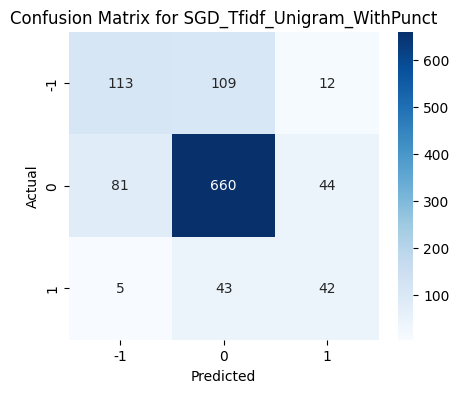


Confusion Matrix for SGD_Tfidf_Unigram:
[[115 107  12]
 [ 82 661  42]
 [  6  45  39]]


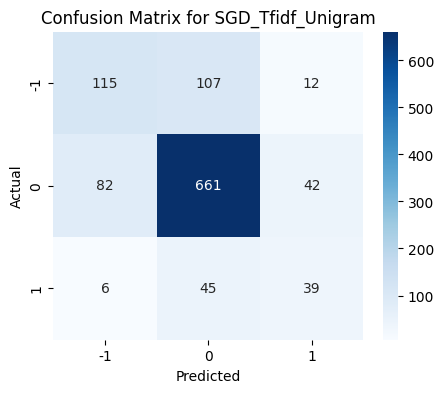


Confusion Matrix for SVM_Tfidf_Ngram_WithPunct:
[[ 84 147   3]
 [ 42 718  25]
 [  0  60  30]]


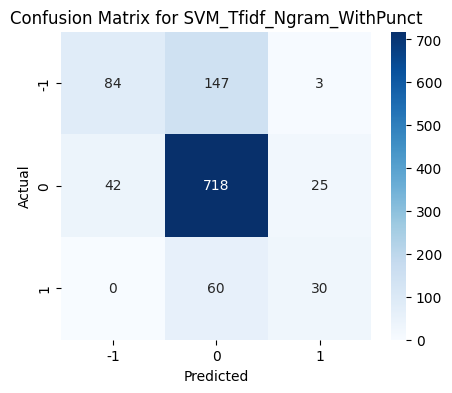


Confusion Matrix for SVM_Tfidf_Ngram:
[[ 82 149   3]
 [ 42 718  25]
 [  0  58  32]]


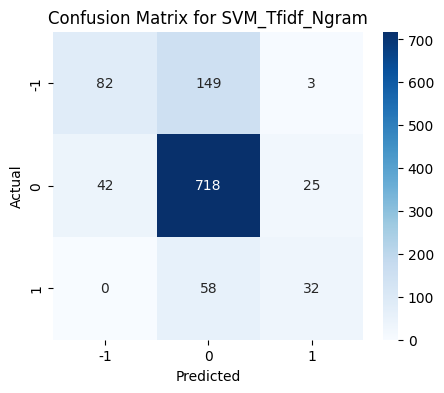


Confusion Matrix for LR_Tfidf_Ngram:
[[116 102  16]
 [ 95 641  49]
 [  3  43  44]]


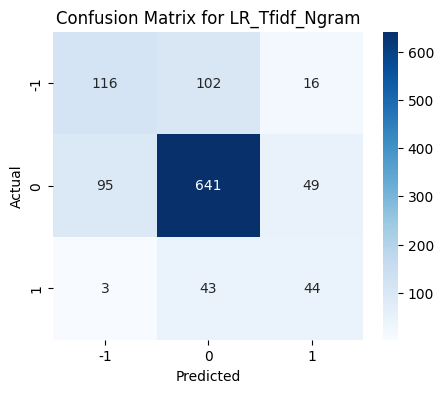

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define desired class labels (adjust as needed)
desired_classes = [-1, 0, +1]

print("\n### Confusion Matrices for Top 5 Pipelines")

# Get the top 5 pipeline names from results_df
top_5_pipelines = results_df.head(5)["Pipeline"]

for pipeline_name in top_5_pipelines:
    # Retrieve the pipeline from the all_pipelines dictionary
    pipe = all_pipelines[pipeline_name]
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    
    # Compute the confusion matrix with the desired class order
    cm = confusion_matrix(y_test, y_pred, labels=desired_classes)
    print(f"\nConfusion Matrix for {pipeline_name}:")
    print(cm)
    
    # Plot the confusion matrix
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=desired_classes, yticklabels=desired_classes)
    plt.title(f"Confusion Matrix for {pipeline_name}")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

## Stage 1 Analysis of Model Performance Metrics

### **Results Analysis of Different Text Classification Pipelines**

This report summarizes the performance of various text classification pipelines that differ in:
1. **Preprocessing**: With or without punctuation removal
2. **Vectorization**: TF–IDF, Count, or Glove embeddings
3. **Dimensionality Reduction**: Some variants use SVD
4. **Classifiers**: SVM, SGD, Logistic Regression, Naive Bayes, KNN, etc.

Below, we highlight two sets of results:
- **Top‐performing pipelines** 
- **Lowest‐performing pipelines** 

All metrics shown here focus primarily on:
- **Accuracy**
- **Precision (weighted)**
- **Recall (weighted)**
- **F1 (weighted)**

---

## **1. Top‐Performing Pipelines**

Here are the highest ranked models by F1_weighted:

| **Pipeline**                       | **Accuracy** | **Precision_weighted** | **Recall_weighted** | **F1_weighted** |
|------------------------------------|-------------:|------------------------:|---------------------:|-----------------:|
| **SGD_Tfidf_Unigram_WithPunct**    |    0.734896  |   0.729248             |   0.734896          |  0.731117        |
| **SGD_Tfidf_Unigram**             |    0.731289  |   0.727229             |   0.731289          |  0.728294        |
| **SVM_Tfidf_Ngram_WithPunct**      |    0.750225  |   0.732084             |   0.750225          |  0.725792        |
| **SVM_Tfidf_Ngram**               |    0.750225  |   0.732365             |   0.750225          |  0.725710        |
| **LR_Tfidf_Ngram**                |    0.722272  |   0.724397             |   0.722272          |  0.723319        |

### **Key Observations (Top Performers)**

1. **TF–IDF Vectorization Dominates**  
   All the top models rely on TF–IDF. This suggests that weighting terms by their inverse document frequency is particularly effective in this dataset.

2. **SGD vs. SVM**  
   - **SGD** (Stochastic Gradient Descent) pipelines with unigram TF–IDF show strong performance, particularly when punctuation is retained (`SGD_Tfidf_Unigram_WithPunct` has an F1_weighted of 0.731117).  
   - **SVM** (LinearSVC) with n‐gram TF–IDF yields high accuracy (0.750225) but slightly lower weighted F1 scores (~0.7257–0.7258). This might indicate that while the SVM is correct more often overall, it may be slightly less balanced across classes in terms of precision and recall.

3. **Impact of Punctuation Removal**  
   - We see both “_WithPunct” and non‐punctuation pipelines among the top. The difference in F1_weighted is relatively small.  
   - For example, `SGD_Tfidf_Unigram_WithPunct` and `SGD_Tfidf_Unigram` differ by about 0.003 in F1_weighted (0.731117 vs. 0.728294).

4. **N‐Gram vs. Unigram**  
   - SVM pipelines using n‐grams (1,2) are performing at or above 72–73% F1_weighted.  
   - SGD pipelines with just unigrams are also competitive. This might imply that capturing bigrams helps SVM, whereas SGD can perform well even with unigrams.

In summary, **SGD and SVM with TF–IDF** are clearly leading in overall performance, with minimal differences between punctuation variants.

---

## **2. Lowest‐Performing Pipelines**

From the second screenshot, here are some of the lower‐ranking models by F1_weighted:

| **Pipeline**                        | **Accuracy** | **Precision_weighted** | **Recall_weighted** | **F1_weighted** |
|-------------------------------------|-------------:|------------------------:|---------------------:|-----------------:|
| **NB_Count_Binary_Ngram_WithPunct** |    0.439134  |   0.750225*            |   0.439134          |  0.463137        |
| **Glove_KNN_WithPunct**            |    0.406673  |   0.066022             |   0.406673          |  0.438178        |
| **Glove_KNN**                      |    0.392245  |   0.250513             |   0.392245          |  0.421605        |
| **KNN_Tfidf_Unigram_WithPunct_SVD** |    0.382326  |   0.598357             |   0.382326          |  0.405969        |
| **KNN_Tfidf_Unigram_SVD**          |    0.377818  |   0.288081             |   0.377818          |  0.396014        |
| **KNN_Tfidf_Ngram_WithPunct_SVD**   |    0.363590  |   0.613323             |   0.363590          |  0.395563        |
| **KNN_Tfidf_Ngram_SVD**            |    0.363309  |   0.584955             |   0.363309          |  0.394329        |


### **Key Observations (Low Performers)**

1. **KNN Struggles**  
   - All the KNN‐based pipelines, whether they use TF–IDF or Glove, tend to show lower accuracy and F1 scores.  
   - Even with dimensionality reduction (SVD), KNN remains among the worst performers. KNN is often sensitive to high‐dimensional spaces and might not be the best fit for textual data unless carefully tuned.

2. **Naive Bayes with Count Binary N‐grams**  
   - While Naive Bayes can be a strong baseline for text classification, here it yields an accuracy of around 43.9% and an F1_weighted of ~0.463. This is significantly lower than the top TF–IDF + SVM/SGD approaches.  
   - The high “Precision_weighted” for NB might be misleading if one class dominates the dataset.

3. **Glove + KNN**  
   - Glove embeddings are generally powerful, but pairing them with KNN in this experiment appears suboptimal. Accuracy in the 39–40% range is considerably below the top TF–IDF methods.  
   - Possibly, a more advanced classifier (like an SVM or a neural net) on top of Glove might perform better than KNN.

Overall, the worst‐performing pipelines tend to involve **KNN** or **Naive Bayes** with certain vectorization strategies (e.g., Count binary n‐grams). This highlights the importance of the right combination of **vectorization** and **classifier**.

### **Conclusion**

- The top pipelines demonstrate that **fine‐grained text transformations (TF–IDF) and strong linear models (SVM, SGD)** are a robust combination.
- The lower‐performing pipelines serve as a reminder that not all classifiers generalize equally well in text classification tasks, especially with high‐dimensional data.  


___________________________________________________________________________________________________________________________________________________________________________________________________________________________________________

---

# E. Stage 2: Parameter Tuning

## Parameter Tuning the top 4 pipelines, evaluating each on 20% test set (from 80 - 20 split)

Pipeline Tuning and Evaluation for Sentiment Analysis

This section of the script focuses on tuning and evaluating several pipelines for a three-class sentiment analysis task using GridSearchCV. The goal is to determine the best hyperparameters for each model and evaluate their performance across multiple metrics.

### Steps Followed

1. **Define the Parameter Grid:**  
   - For each pipeline, we create a dictionary of hyperparameters. 
2. **Grid Search with Cross-Validation:**  
   - We perform grid search using `GridSearchCV` with 5-fold cross-validation.
   - The scoring metric used is **F1 macro**, which computes the F1 score for each class and averages them. This is effective in multi-class sentiment analysis, as it treats all classes equally even if the data is balanced.

3. **Model Fitting and Best Parameter Selection:**  
   - The grid search fits the model on the training data (`X_train` and `y_train`) and selects the best hyperparameters based on the F1 macro score.
   - The best parameters are printed for review.

4. **Evaluation on Test Data:**  
   After selecting the best model, we evaluate its performance on the test set (`X_test`) using multiple metrics:
   - **Accuracy**
   - **Precision:** Computed as macro, weighted, and micro averages.
   - **Recall:** Computed as macro, weighted, and micro averages.
   - **F1 Score:** Computed as macro, weighted, and micro averages.

5. **Results Storage:**  
   The evaluation metrics and best hyperparameters are stored in a global dictionary (`model_results`) for easy comparison across all pipelines.

In [32]:
# Dictionary to hold results for all models
model_results = {}

In [ ]:
# Extended parameter grid for SGD_Tfidf_Unigram_WithPunct
param_grid = {
    'vectorizer__ngram_range': [(1,1)],  # fixed for unigram
    'classifier__loss': ['modified_huber', 'huber', 'perceptron'],
    'classifier__penalty': ['l2', 'l1', 'elasticnet'],
    'classifier__alpha': [0.001, 0.01],
    'classifier__learning_rate': ['optimal', 'invscaling', 'adaptive'],
    'classifier__eta0': [0.0, 0.1]
}

gs = GridSearchCV(all_pipelines["SGD_Tfidf_Unigram_WithPunct"],
                  param_grid,
                  cv=5,
                  scoring='f1_weighted',
                  n_jobs=1,
                  verbose=1)
gs.fit(X_train, y_train)

print("Best Parameters for SGD_Tfidf_Unigram_WithPunct:")
print(gs.best_params_)

# Evaluate on test data
y_pred = gs.predict(X_test)
acc = accuracy_score(y_test, y_pred)
precision_macro = precision_score(y_test, y_pred, average='macro')
precision_weighted = precision_score(y_test, y_pred, average='weighted')
precision_micro = precision_score(y_test, y_pred, average='micro')
recall_macro = recall_score(y_test, y_pred, average='macro')
recall_weighted = recall_score(y_test, y_pred, average='weighted')
recall_micro = recall_score(y_test, y_pred, average='micro')
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_weighted = f1_score(y_test, y_pred, average='weighted')
f1_micro = f1_score(y_test, y_pred, average='micro')

print("\nTest Metrics for SGD_Tfidf_Unigram_WithPunct:")
print("Accuracy:", acc)
print("Precision - Macro:", precision_macro, "Weighted:", precision_weighted, "Micro:", precision_micro)
print("Recall    - Macro:", recall_macro, "Weighted:", recall_weighted, "Micro:", recall_micro)
print("F1 Score  - Macro:", f1_macro, "Weighted:", f1_weighted, "Micro:", f1_micro)

# Confusion Matrix Plot
desired_classes = [-1, 0, 1]
cm = confusion_matrix(y_test, y_pred, labels=desired_classes)
print("\nConfusion Matrix:")
print(cm)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=desired_classes, yticklabels=desired_classes)
plt.title("Confusion Matrix for SGD_Tfidf_Unigram_WithPunct")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

# Optionally, save results in a dictionary
model_results = {}
model_results['SGD_Tfidf_Unigram_WithPunct'] = {
    'best_params': gs.best_params_,
    'accuracy': acc,
    'precision_macro': precision_macro,
    'precision_weighted': precision_weighted,
    'precision_micro': precision_micro,
    'recall_macro': recall_macro,
    'recall_weighted': recall_weighted,
    'recall_micro': recall_micro,
    'f1_macro': f1_macro,
    'f1_weighted': f1_weighted,
    'f1_micro': f1_micro
}


Fitting 5 folds for each of 108 candidates, totalling 540 fits


In [ ]:
# Extended parameter grid for SGD_Tfidf_Unigram (without punctuation removal)
param_grid = {
    'vectorizer__ngram_range': [(1,1)],  # fixed for unigram
    'classifier__loss': ['modified_huber', 'huber', 'perceptron'],
    'classifier__penalty': ['l2', 'l1', 'elasticnet'],
    'classifier__alpha': [0.001, 0.01],
    'classifier__learning_rate': ['optimal', 'invscaling', 'adaptive'],
    'classifier__eta0': [0.0, 0.1]
}

gs = GridSearchCV(all_pipelines["SGD_Tfidf_Unigram"],
                  param_grid,
                  cv=5,
                  scoring='f1_weighted',
                  n_jobs=1,
                  verbose=1)
gs.fit(X_train, y_train)

print("Best Parameters for SGD_Tfidf_Unigram:")
print(gs.best_params_)

# Evaluate on test data
y_pred = gs.predict(X_test)
acc = accuracy_score(y_test, y_pred)
precision_macro = precision_score(y_test, y_pred, average='macro')
precision_weighted = precision_score(y_test, y_pred, average='weighted')
precision_micro = precision_score(y_test, y_pred, average='micro')
recall_macro = recall_score(y_test, y_pred, average='macro')
recall_weighted = recall_score(y_test, y_pred, average='weighted')
recall_micro = recall_score(y_test, y_pred, average='micro')
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_weighted = f1_score(y_test, y_pred, average='weighted')
f1_micro = f1_score(y_test, y_pred, average='micro')

print("\nTest Metrics for SGD_Tfidf_Unigram:")
print("Accuracy:", acc)
print("Precision - Macro:", precision_macro, "Weighted:", precision_weighted, "Micro:", precision_micro)
print("Recall    - Macro:", recall_macro, "Weighted:", recall_weighted, "Micro:", recall_micro)
print("F1 Score  - Macro:", f1_macro, "Weighted:", f1_weighted, "Micro:", f1_micro)

# Confusion Matrix Plot
desired_classes = [-1, 0, 1]
cm = confusion_matrix(y_test, y_pred, labels=desired_classes)
print("\nConfusion Matrix:")
print(cm)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=desired_classes, yticklabels=desired_classes)
plt.title("Confusion Matrix for SGD_Tfidf_Unigram")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

model_results['SGD_Tfidf_Unigram'] = {
    'best_params': gs.best_params_,
    'accuracy': acc,
    'precision_macro': precision_macro,
    'precision_weighted': precision_weighted,
    'precision_micro': precision_micro,
    'recall_macro': recall_macro,
    'recall_weighted': recall_weighted,
    'recall_micro': recall_micro,
    'f1_macro': f1_macro,
    'f1_weighted': f1_weighted,
    'f1_micro': f1_micro
}


Fitting 5 folds for each of 108 candidates, totalling 540 fits


KeyboardInterrupt: 

In [ ]:
# Extended parameter grid for SVM_Tfidf_Ngram_WithPunct
param_grid = {
    'vectorizer__ngram_range': [(1,2)],  # fixed for ngram (1,2)
    'vectorizer__use_idf': [True, False],
    'vectorizer__smooth_idf': [True, False],
    'classifier__C': [1, 10, 100],
    'classifier__loss': ['hinge', 'squared_hinge'],
    'classifier__dual': [True, False],
    'classifier__tol': [1e-4, 1e-3, 1e-2]
}

gs = GridSearchCV(all_pipelines["SVM_Tfidf_Ngram_WithPunct"],
                  param_grid,
                  cv=5,
                  scoring='f1_weighted',
                  n_jobs=1,
                  verbose=1)
gs.fit(X_train, y_train)

print("Best Parameters for SVM_Tfidf_Ngram_WithPunct:")
print(gs.best_params_)

# Evaluate on test data
y_pred = gs.predict(X_test)
acc = accuracy_score(y_test, y_pred)
precision_macro = precision_score(y_test, y_pred, average='macro')
precision_weighted = precision_score(y_test, y_pred, average='weighted')
precision_micro = precision_score(y_test, y_pred, average='micro')
recall_macro = recall_score(y_test, y_pred, average='macro')
recall_weighted = recall_score(y_test, y_pred, average='weighted')
recall_micro = recall_score(y_test, y_pred, average='micro')
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_weighted = f1_score(y_test, y_pred, average='weighted')
f1_micro = f1_score(y_test, y_pred, average='micro')

print("\nTest Metrics for SVM_Tfidf_Ngram_WithPunct:")
print("Accuracy:", acc)
print("Precision - Macro:", precision_macro, "Weighted:", precision_weighted, "Micro:", precision_micro)
print("Recall    - Macro:", recall_macro, "Weighted:", recall_weighted, "Micro:", recall_micro)
print("F1 Score  - Macro:", f1_macro, "Weighted:", f1_weighted, "Micro:", f1_micro)

# Confusion Matrix Plot
desired_classes = [-1, 0, 1]
cm = confusion_matrix(y_test, y_pred, labels=desired_classes)
print("\nConfusion Matrix:")
print(cm)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=desired_classes, yticklabels=desired_classes)
plt.title("Confusion Matrix for SVM_Tfidf_Ngram_WithPunct")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=0))



model_results['SVM_Tfidf_Ngram_WithPunct'] = {
    'best_params': gs.best_params_,
    'accuracy': acc,
    'precision_macro': precision_macro,
    'precision_weighted': precision_weighted,
    'precision_micro': precision_micro,
    'recall_macro': recall_macro,
    'recall_weighted': recall_weighted,
    'recall_micro': recall_micro,
    'f1_macro': f1_macro,
    'f1_weighted': f1_weighted,
    'f1_micro': f1_micro
}


Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best Parameters for LR_Tfidf_Ngram:
{'classifier__C': 1, 'classifier__class_weight': 'balanced', 'vectorizer__ngram_range': (1, 2), 'vectorizer__use_idf': True}
Test Metrics for LR_Tfidf_Ngram:
Accuracy: 0.7321911632100991
Precision - Macro: 0.600318552601035 Weighted: 0.7294454546067841 Micro: 0.7321911632100991
Recall    - Macro: 0.5977719095294677 Weighted: 0.7321911632100991 Micro: 0.7321911632100991
F1 Score  - Macro: 0.5986477334344934 Weighted: 0.7305738680821262 Micro: 0.7321911632100991


In [ ]:
# Extended parameter grid for SVM_Tfidf_Ngram (without punctuation removal)
param_grid = {
    'vectorizer__ngram_range': [(1,2)],  # fixed for ngram (1,2)
    'vectorizer__use_idf': [True, False],
    'vectorizer__smooth_idf': [True, False],
    'classifier__C': [1, 10, 100],
    'classifier__loss': ['hinge', 'squared_hinge'],
    'classifier__dual': [True, False],
    'classifier__tol': [1e-4, 1e-3, 1e-2]
}

gs = GridSearchCV(all_pipelines["SVM_Tfidf_Ngram"],
                  param_grid,
                  cv=5,
                  scoring='f1_weighted',
                  n_jobs=1,
                  verbose=1)
gs.fit(X_train, y_train)

print("Best Parameters for SVM_Tfidf_Ngram:")
print(gs.best_params_)

# Evaluate on test data
y_pred = gs.predict(X_test)
acc = accuracy_score(y_test, y_pred)
precision_macro = precision_score(y_test, y_pred, average='macro')
precision_weighted = precision_score(y_test, y_pred, average='weighted')
precision_micro = precision_score(y_test, y_pred, average='micro')
recall_macro = recall_score(y_test, y_pred, average='macro')
recall_weighted = recall_score(y_test, y_pred, average='weighted')
recall_micro = recall_score(y_test, y_pred, average='micro')
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_weighted = f1_score(y_test, y_pred, average='weighted')
f1_micro = f1_score(y_test, y_pred, average='micro')

print("\nTest Metrics for SVM_Tfidf_Ngram:")
print("Accuracy:", acc)
print("Precision - Macro:", precision_macro, "Weighted:", precision_weighted, "Micro:", precision_micro)
print("Recall    - Macro:", recall_macro, "Weighted:", recall_weighted, "Micro:", recall_micro)
print("F1 Score  - Macro:", f1_macro, "Weighted:", f1_weighted, "Micro:", f1_micro)

# Confusion Matrix Plot
desired_classes = [-1, 0, 1]
cm = confusion_matrix(y_test, y_pred, labels=desired_classes)
print("\nConfusion Matrix:")
print(cm)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=desired_classes, yticklabels=desired_classes)
plt.title("Confusion Matrix for SVM_Tfidf_Ngram")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

model_results['SVM_Tfidf_Ngram'] = {
    'best_params': gs.best_params_,
    'accuracy': acc,
    'precision_macro': precision_macro,
    'precision_weighted': precision_weighted,
    'precision_micro': precision_micro,
    'recall_macro': recall_macro,
    'recall_weighted': recall_weighted,
    'recall_micro': recall_micro,
    'f1_macro': f1_macro,
    'f1_weighted': f1_weighted,
    'f1_micro': f1_micro
}


Fitting 5 folds for each of 48 candidates, totalling 240 fits


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear fail

Best Parameters for SVM_Tfidf_Unigram:
{'classifier__C': 1, 'classifier__class_weight': 'balanced', 'classifier__loss': 'squared_hinge', 'vectorizer__max_df': 0.9, 'vectorizer__min_df': 2, 'vectorizer__ngram_range': (1, 1), 'vectorizer__use_idf': False}
Test Metrics for SVM_Tfidf_Unigram:
Accuracy: 0.7276825969341749
Precision - Macro: 0.59049139842036 Weighted: 0.7173221303949213 Micro: 0.7276825969341749
Recall    - Macro: 0.5664867359537832 Weighted: 0.7276825969341749 Micro: 0.7276825969341749
F1 Score  - Macro: 0.5769678402386047 Weighted: 0.7213548930090299 Micro: 0.7276825969341749


In [ ]:
# Convert the model_results dictionary into a DataFrame for easy comparison
results_df = pd.DataFrame(model_results).T.reset_index().rename(columns={'index': 'Model'})

# Sort by F1_weighted (descending order)
results_df = results_df.sort_values(by="f1_weighted", ascending=False)

# Save the results DataFrame to a CSV file
csv_filename = "top_4_HPT_model_comparison_results.csv"
results_df.to_csv(csv_filename, index=False)
print(f"Results saved to {csv_filename}")

# Display the results as a scrollable table
html_table = results_df.to_html(classes="table table-striped", border=1, index=False)
display(HTML(f"""
<style>
    .dataframe-container {{
        max-height: 400px;
        overflow-y: scroll;
    }}
</style>
<div class="dataframe-container">
    {html_table}
</div>
"""))

                    Model                                        best_params  \
0         SVM_Tfidf_Ngram  {'classifier__C': 1, 'classifier__loss': 'squa...   
1   LR_Count_Binary_Ngram  {'classifier__C': 0.1, 'classifier__class_weig...   
2          LR_Tfidf_Ngram  {'classifier__C': 1, 'classifier__class_weight...   
3       SVM_Tfidf_Unigram  {'classifier__C': 1, 'classifier__class_weight...   
4  SVM_Count_Binary_Ngram  {'classifier__C': 0.1, 'classifier__class_weig...   

  accuracy precision_macro precision_weighted precision_micro recall_macro  \
0   0.7448          0.6197             0.7277          0.7448       0.5674   
1   0.7124          0.5682             0.7077          0.7124       0.5619   
2   0.7322          0.6003             0.7294          0.7322       0.5978   
3   0.7277          0.5905             0.7173          0.7277       0.5665   
4   0.7385          0.6150             0.7187          0.7385       0.5515   

  recall_weighted recall_micro f1_macro f1_weighte

## Stage 2 Analysis of Model Performance Metrics

## Key Observations



----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------